In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense
from sklearn.svm import SVC

2024-06-20 13:41:45.231167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 13:41:45.231286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 13:41:45.363413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Data

In [2]:
!mkdir -p /kaggle/working/dataset/train/fresh
!mkdir -p /kaggle/working/dataset/train/rotten
!mkdir -p /kaggle/working/dataset/test/fresh
!mkdir -p /kaggle/working/dataset/test/rotten

In [3]:
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/* /kaggle/working/dataset/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshbanana/* /kaggle/working/dataset/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshoranges/* /kaggle/working/dataset/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenapples/* /kaggle/working/dataset/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenbanana/* /kaggle/working/dataset/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenoranges/* /kaggle/working/dataset/train/rotten

!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshapples/* /kaggle/working/dataset/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/* /kaggle/working/dataset/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshoranges/* /kaggle/working/dataset/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/* /kaggle/working/dataset/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenbanana/* /kaggle/working/dataset/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenoranges/* /kaggle/working/dataset/test/rotten

In [4]:
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, target_size)  # Resize the image
                images.append(img)
                labels.append(class_label)
    return np.array(images), np.array(labels)

In [5]:
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'

X_train, y_train = load_and_resize_images_from_folder(TRAIN_PATH)
X_test, y_test = load_and_resize_images_from_folder(TEST_PATH)
# Split the training data into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

## Visualization

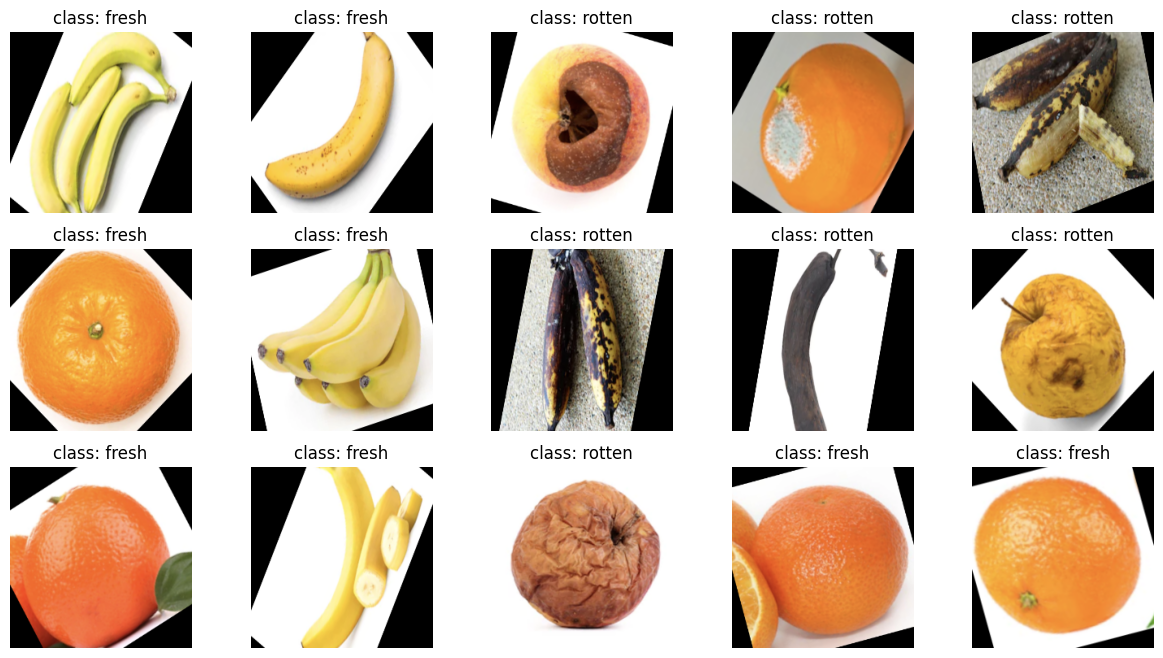

In [6]:
import random
#desplaying the train data
random_indices = random.sample(range(len(X_train)), 15)

# Plot the images
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3,5, i)
    plt.imshow(X_train[index])
    plt.title(f'class: {y_train[index]}')
    plt.axis('off')

plt.show()

## Feature Extraction using VGG16

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
X_train_features = model.predict(X_train)
X_validation_features = model.predict(X_val)
X_test_features = model.predict(X_test)

85/85 [==============================] - 13s 159ms/step


## Feature Selection Using Genetics Algorithm

In [10]:
# Fitness Function
def evaluate_features(ind):
    # ind is a binary array representing selected features
    selected_features = np.where(ind)[0]
    X_train_selected = X_train_features[:, selected_features]
    X_validation_selected = X_validation_features[:, selected_features]

    # Train an SVM classifier with selected features
    svm_classifier = SVC(kernel='linear', C=1.0)
    svm_classifier.fit(X_train_selected, y_train)

    # Evaluate the SVM classifier
    accuracy = svm_classifier.score(X_validation_selected, y_val)

    return accuracy,

In [11]:
from deap import base, creator, tools, algorithms

# Define genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = X_train_features.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_features)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create an initial population of individuals
population = toolbox.population(n=10)

# Run the genetic algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=20, cxpb=0.7, mutpb=0.2, ngen=5, stats=None, halloffame=None)

gen	nevals
0  	10    
1  	16    
2  	17    
3  	20    
4  	20    
5  	18    


([[1,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   1

In [12]:
# Get the best individual
best_individual = tools.selBest(population, k=1)[0]

# Apply selected features to the data
selected_features = np.where(best_individual)[0]
X_train_selected = X_train_features[:, selected_features]
X_validation_selected = X_validation_features[:, selected_features]
X_test_selected = X_test_features[:, selected_features]

In [13]:
print(f"Number of features before selection: {len(X_train_features[1])}")
print(f"Number of features after selection: {len(X_train_selected[1])}")

Number of features before selection: 512
Number of features after selection: 259


In [14]:
# Train an SVM classifier with selected features
final_svm_classifier = SVC(kernel='linear', C=1.0)
final_svm_classifier.fit(X_train_selected, y_train)

SVC(kernel='linear')

In [15]:
# Evaluate the final SVM classifier with selected features
accuracy = final_svm_classifier.score(X_test_selected, y_test)
print(f"Accuracy on test set with selected features: {(accuracy *100):0.0f} %")

Accuracy on test set with selected features: 98 %


## Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
y_predicted = final_svm_classifier.predict(X_test_selected)
confusion = confusion_matrix(y_test,y_predicted,labels=['fresh','rotten'])

Text(0.5, 25.722222222222214, 'Predicted label')

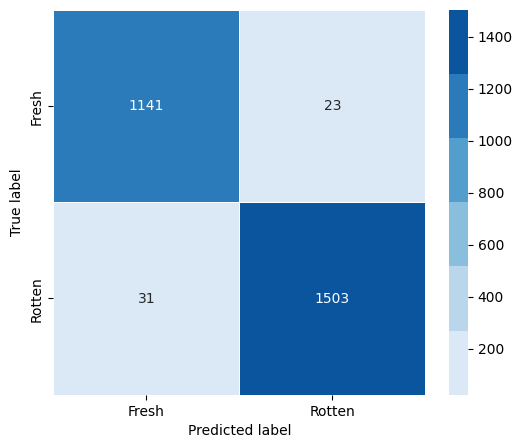

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
target_names = ['Fresh','Rotten']
fig, ax = plt.subplots(figsize=(6,5)) 
sns.heatmap(confusion, annot=True,ax=ax,fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"),xticklabels=target_names, yticklabels=target_names);
plt.ylim([ 2,0,]);
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Precision, Recall, F1-score

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predicted, target_names=target_names))

              precision    recall  f1-score   support

       Fresh       0.97      0.98      0.98      1164
      Rotten       0.98      0.98      0.98      1534

    accuracy                           0.98      2698
   macro avg       0.98      0.98      0.98      2698
weighted avg       0.98      0.98      0.98      2698

